# Initial Setup

In [1]:
import os
import copy as copy
from math import pi
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns

from PIL import Image, ImageDraw

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Input, Convolution2D, MaxPooling2D, InputLayer, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.palettes import Category20c
from bokeh.transform import cumsum

from io import BytesIO
import base64
from IPython.core.display import display, HTML

from src.cv.data.raw_data_access import get_partitions_csv, get_features_csv

pd.set_option("display.max_columns", 42)
pd.options.plotting.backend = 'hvplot'
output_notebook()

Using TensorFlow backend.


Loading BokehJS ...

# Utils

In [2]:
# Paths de los datos a utilizar (directorio de las imagenes y csv): CAMBIAR CON LOS QUE CORRESPONDAN
IMAGES_PATH = r"C:\Users\santi\Desktop\TP3"
# IMAGES_PATH = r"C:\Users\agus_\Desktop\ML_Grupo_2\imagenes_tp3_cv"

# Porcentaje de datos con los que me voy a quedar de los conjuntos train, test y validation originales
GLOBAL_FRAC = 0.5

# Datos generales
IMAGE_CHANNELS = 3
IMAGE_HEIGHT = 70
IMAGE_WIDTH = 70

BATCH_SIZE = 32

sgd = SGD(lr=0.01,momentum=0.9,nesterov=True)

In [3]:
def get_train_test_validation(total=False, frac=GLOBAL_FRAC):
    df_images_target = get_features_csv()
    df_images_target.columns = df_images_target.columns.str.lower()
    df_images_target.set_index('image_id', inplace=True)
    
    df_images_target = df_images_target.replace(-1, 0)
    
    df_images_partition = get_partitions_csv()
    df_images_partition.columns = df_images_partition.columns.str.lower()
    df_images_partition.set_index('image_id', inplace=True)
    
    df_images_target["partition"] = df_images_partition["partition"]
    
    df_train = df_images_target[df_images_target.partition == 0].sample(frac=frac, random_state=1)
    df_test = df_images_target[df_images_target.partition == 1].sample(frac=frac, random_state=1)
    df_validation = df_images_target[df_images_target.partition == 2].sample(frac=frac, random_state=1)
    
    if total:
        return pd.concat([df_train, df_test, df_validation])
    else:
        df_train.reset_index(inplace=True)
        df_test.reset_index(inplace=True)
        df_validation.reset_index(inplace=True)
        
        # Necesitamos que el target sea de tipo string porque ImageDataGenerator.flow_from_dataframe asi lo requiere
        df_train['smiling'] = df_train['smiling'].astype(str)
        df_test['smiling'] = df_test['smiling'].astype(str)
        df_validation['smiling'] = df_validation['smiling'].astype(str)

        return df_train[['image_id', "smiling"]], df_test[['image_id', "smiling"]], df_validation[['image_id', "smiling"]]

In [4]:
def make_data_volume(df, part, tot=False):
    if tot:
        _df = df.copy()
    else:
        _df = df[df.partition == part].copy()
    
    _df.drop('partition', axis=1, inplace=True)
    _df = _df.apply(pd.Series.value_counts)
    _df.rename(index={0: 'No', 1: 'Yes'}, inplace=True)
    return _df.T

In [5]:
def get_generator(df, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, batch_size=BATCH_SIZE):
    data_gen = ImageDataGenerator(
        rescale=1./255,
    )
    generator = data_gen.flow_from_dataframe(
        # Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
        dataframe=df,
        # Path to the folder which contains all the images.
        directory=IMAGES_PATH,
        # The column in the dataframe that has the filenames of the images.
        x_col='image_id',
        # Column in dataframe that has the target data.
        y_col='smiling',
        # Mode for yielding the targets.
        class_mode="binary",
        # Size of the batches of data.
        batch_size=batch_size,
        # Whether to shuffle the data.
        shuffle=False,
        # Random seed for shuffling and transformations.
        seed=1,
        # The dimensions to which all images found will be resized.
        target_size=(height,width)
    )
    return generator

In [6]:
def evaluate_model(model, generators, title='', show_cm=True, batch_size=BATCH_SIZE):
    if title:
        display(title)
    final_metrics = defaultdict(list)
    set_names = []
    if show_cm:
        fig, axis = plt.subplots(1, len(generators), sharey=True, figsize=(15, 3))
        
    i = -1
    for set_name, set_generator in generators:
        set_names.append(set_name)
        i = i+1

        y = set_generator.classes
        steps = len(y) // batch_size + 1
        prediction = model.predict_generator(set_generator, steps, workers=4, verbose=1)
        pred = prediction.round()
        y_pred = list(map(int,list(itertools.chain.from_iterable(pred))))

        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        final_metrics['Recall'].append(metrics.recall_score(y, y_pred))
        final_metrics['F1'].append(metrics.f1_score(y, y_pred))

        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Greens', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['No sonríe', 'Sonríe'])
            ax.yaxis.set_ticklabels(['No sonríe', 'Sonríe'])
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')
            
    display(pd.DataFrame(final_metrics, index=tuple(set_names)))
    if show_cm:
        plt.tight_layout()
        plt.show()

In [7]:
def plot_learning_curve(model_history):
    axes = plt.gca() 
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.title('Evolución de Accuracy durante el entrenamiento')
    plt.ylabel('Accuracy')
    plt.xlabel('Época')
    plt.legend(loc='lower right')
    axes.set_ylim([0,1])
    plt.show()

In [8]:
def img_to_display(filename):
    i = Image.open(os.path.join(IMAGES_PATH,filename))
    
    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [9]:
def get_predict_samples(df, model, corret_prediction, quantity=16, random_state=1, batch_size=BATCH_SIZE):
    # Busco ejemplos random del dataset
    df_sample = df.sample(frac=0.5, random_state=random_state)
    
    df_sample.reset_index(inplace=True)
    df_sample.drop(['index'], axis=1, inplace=True)
    
    # Obtengo el generador
    df_sample_generator = get_generator(df_sample)
    
    # Reseteo generador
    df_sample_generator.reset()
    
    # Predigo
    y = df_sample_generator.classes
    steps = len(y) // batch_size + 1
    prediction = model.predict_generator(df_sample_generator, steps, workers=4)
    pred = prediction.round()
    prediction_class = list(map(int,list(itertools.chain.from_iterable(pred))))
    
    df_sample['true_class'] = y
    df_sample['pred_class'] = prediction_class
    df_sample['prediction'] = prediction
    
    df_sample = df_sample[(df_sample.true_class==df_sample.pred_class)==corret_prediction]
    
    # Reseteo el indice para que vaya del 0 al quantity
    df_sample.reset_index(inplace=True)
    
    desc = {0: 'Not Smiling',
        1: 'Smiling'}
    display_html = '''
    '''
    for i in range(df_sample.shape[0]):

        filename = df_sample.iloc[i:i+1]['image_id'].values[0]
        
        if(i%2 == 0):
            zone='left'
        else:
            zone='right'
        
        display_html += '''
        <div style="border: 2px solid #D8D8D8; float:{}; width: 45%;" >
            <img src="data:image/jpeg;base64,{}" style="float: left; padding: 5px 5px 5px 5px">
            <div style="padding: 10px 0px 0px 15px; overflow: auto;">
                <h2>{}</h2>
                <p style="margin-top: 5px; font-size: 16px">Probability: {}</p>
                <p style="margin-top: 1px; font-size: 16px">Real Target: {}</p>
            </div>
        </div>
        '''.format(zone
                   , img_to_display(filename)
                   , desc[df_sample.iloc[i:i+1]['pred_class'].values[0]]
                   , "{0:.2f}%".format(round(df_sample.iloc[i:i+1]['prediction'].values[0]*100,2))
                   , desc[df_sample.iloc[i:i+1]['true_class'].values[0]]
                   )
        if(i+1==quantity):
            break
    display(HTML(display_html))

In [10]:
def show_images(df, height=IMAGE_HEIGHT, width=IMAGE_WIDTH, chanels=IMAGE_CHANNELS, random_state=1, figsize=(15,9)):
    df = df.sample(15, random_state=random_state)
    
    X, y = get_generator(df, height=height, width=width).next()
    
    desc = {0: 'Not smiling',
            1: 'Smiling'}

    plt.figure(figsize=figsize)
    for i in range(3):
        for j in range(5):
            plt.subplot(3, 5, (i*5)+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            image = copy.copy(X[(i*5)+j])
            plt.imshow(image.reshape(height, width, chanels), cmap=plt.cm.binary)
            plt.xlabel(desc[y[(i*5)+j]])

# Read data

**Lectura del set de datos con el que se trabajará**

In [11]:
p = round(GLOBAL_FRAC*100, 2)
print("Debido a la cantidad elevada de imagenes y a las limitaciones de hardware se trabajará con una fracción")
print(f"del dataset original. Este corresponde al {p}% del mismo.")

Debido a la cantidad elevada de imagenes y a las limitaciones de hardware se trabajará con una fracción
del dataset original. Este corresponde al 50.0% del mismo.


In [12]:
# Se obtiene el conjunto total de datos que se usarán (total=True)
df_data = get_train_test_validation(total=True)

**División del set de datos**

Obtenemos los datasets correspondiente a train, test y validation que utilizaremos para entrenar y validar los modelos.

In [13]:
# Se obtienen los datos corresponidentes a los conjuntos de train, test y validation
df_train, df_test, df_validation = get_train_test_validation()

# Exploratory data analysis

**Objetivo del presente cuaderno:**

El objetivo que se busca con el presente notebook es desarrollar un modelo que sea capaz de detectar una persona que se encuentra en una imagen está sonriendo o no. Nos enfocaremos en la creación y entrenamiento de modelos de clasificación utilizando redes neuronales.

**Descripción del conjunto de datos:**

Dentro de los datos proporcionados contaremos con imágenes recortadas de las personas, correspondientes a los rostros de las mismas. Por cada una de esas imágenes tendremos diversos atributos de las personas que se encuentran en cada imagen. De estos atributos extraeremos nuestro target, el cual indicará a si la persona sonríe o no (columna "smiling" del dataset).

Una vez dicho esto comenzaremos con un breve análisis exploratorio de los datos.

## Target distribution

Como podemos observar en el siguiente grafico de torta, el target se encuentra casi perfectamente balanceado.

In [14]:
vc = df_data.smiling.value_counts().to_frame()
vc.rename(columns={'smiling': 'value'}, inplace=True)

mask = vc.index == 0

vc.loc[::, 'target'] = 'Sonríe (1)'
vc.loc[mask, 'target'] = 'No sonríe (0)'

x = {
    'No sonríe (0)': vc[vc.index == 0].value.values[0],
    'Sonrie (1)': vc[vc.index == 1].value.values[0]
}

vc['angle'] = vc['value'] / vc['value'].sum() * 2 * pi
vc['color'] = ['#3182bd', '#e6550d']

p = figure(plot_height=350, title="Distribución del target", toolbar_location=None,
           tools="hover", tooltips="@target: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='target', source=vc)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

In [15]:
p = round((len(df_data[df_data.smiling == 1])/len(df_data))*100, 2)
print(f"La cantidad de personas que están sonriendo representan el {p}% del conjunto de datos.")
print(f"La cantidad de personas que no están sonriendo representan el {100-p}% del conjunto de datos.")

La cantidad de personas que están sonriendo representan el 48.27% del conjunto de datos.
La cantidad de personas que no están sonriendo representan el 51.73% del conjunto de datos.


## Data volume

El volumen de datos con los que estaremos trabajando es el siguiente:

In [16]:
print("Cantidad total de imágenes:", len(df_data), "\n")
print("Cantidad en train:", len(df_train))
print("Cantidad en test:", len(df_test))
print("Cantidad en validation:", len(df_validation))

Cantidad total de imágenes: 101300 

Cantidad en train: 81385
Cantidad en test: 9934
Cantidad en validation: 9981


**Total data volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles del dataframe total es la siguiente:

In [17]:
make_data_volume(df_data, 0, tot=True)

,No,Yes
5_o_clock_shadow,90106,11194
arched_eyebrows,74064,27236
attractive,49299,52001
bags_under_eyes,80612,20688
bald,99085,2215
bangs,85975,15325
big_lips,77012,24288
big_nose,77457,23843
black_hair,76929,24371
blond_hair,86298,15002


**Train volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en train es la siguiente:

In [18]:
make_data_volume(df_data, 0)

,No,Yes
5_o_clock_shadow,72362,9023
arched_eyebrows,59563,21822
attractive,39473,41912
bags_under_eyes,64784,16601
bald,79605,1780
bangs,69100,12285
big_lips,61867,19518
big_nose,62190,19195
black_hair,61761,19624
blond_hair,69285,12100


**Test volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en test es la siguiente:

In [19]:
make_data_volume(df_data, 1)

,No,Yes
5_o_clock_shadow,8766,1168
arched_eyebrows,7386,2548
attractive,4760,5174
bags_under_eyes,7879,2055
bald,9725,209
bangs,8459,1475
big_lips,8434,1500
big_nose,7433,2501
black_hair,7862,2072
blond_hair,8394,1540


**Validation volumes**

La cantidad de casos positivos y negativos de cada una de las features disponibles en validation es la siguiente:

In [20]:
make_data_volume(df_data, 2)

,No,Yes
5_o_clock_shadow,8978,1003
arched_eyebrows,7115,2866
attractive,5066,4915
bags_under_eyes,7949,2032
bald,9755,226
bangs,8416,1565
big_lips,6711,3270
big_nose,7834,2147
black_hair,7306,2675
blond_hair,8619,1362


## Images type and structure

El conjunto de imágenes original con las que contamos tienen una dimension de 178x218 píxeles y 3 canales de profundidad (RGB).
Debido a que no contamos con una GPU dedicada en nuestros ordenadores que sea compatible, la cual nos permita agilizar los calculos internos que se llevan a cabo en el entrenamiento de los modelos, decidimos hacer un reshape de las mismas a un tamaño de 70x70 píxeles, manteniendo la profundidad de 3.

Esto nos permitirá reducir los pesos que el modelo tenga que aprender, y así lograr resultados más rápidos.

**Ejemplos de las imágenes originales:**

Found 15 validated image filenames belonging to 2 classes.


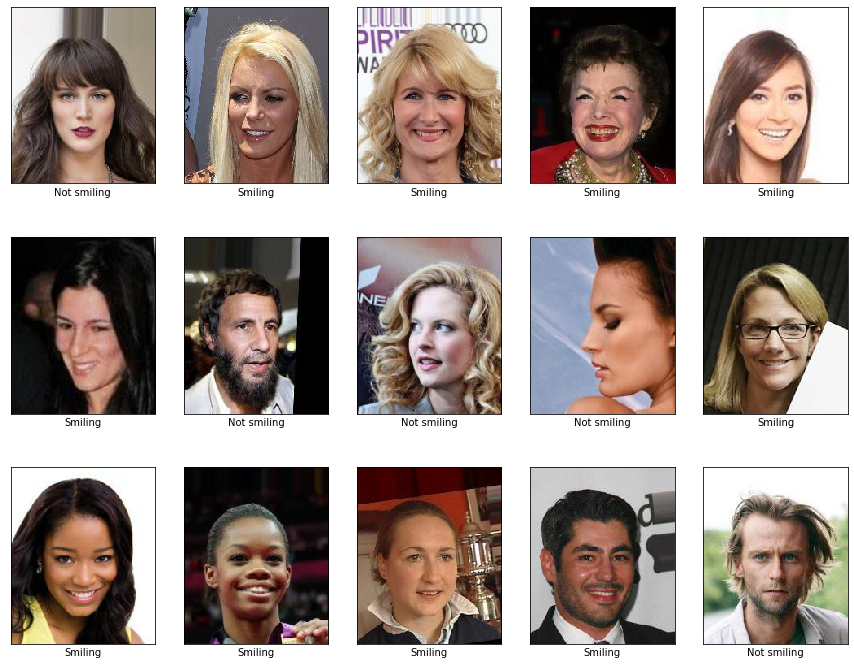

In [21]:
show_images(df=pd.concat([df_train, df_test, df_validation]), height=218, width=178, figsize=(15,12))

**Ejemplos de las imágenes una vez hecho el reshape:**

Found 15 validated image filenames belonging to 2 classes.


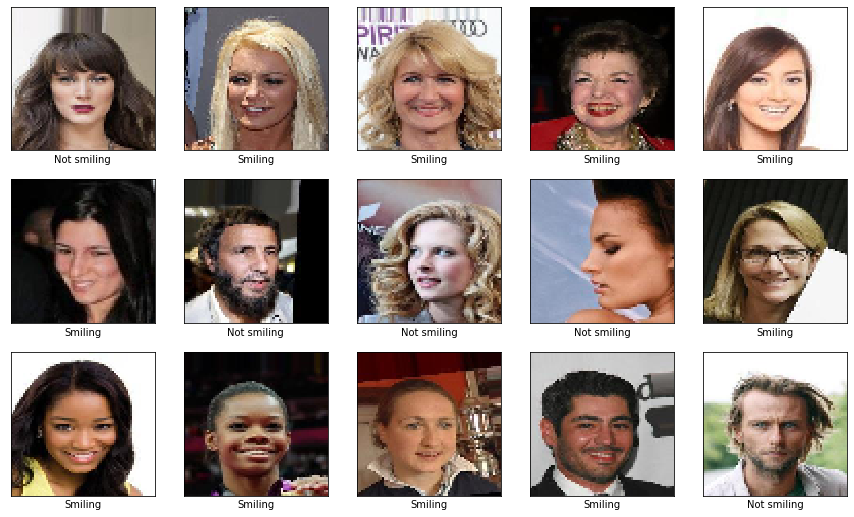

In [22]:
show_images(df=pd.concat([df_train, df_test, df_validation]))

# Experiments

## Multi Layer Perceptron (MLP)

### Image Generator

In [23]:
# Obtenemos el gerador para cada conjunto de datos
MLP_train_generator = get_generator(df_train)
MLP_test_generator = get_generator(df_test)
MLP_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 9934 validated image filenames belonging to 2 classes.
Found 9981 validated image filenames belonging to 2 classes.


### Models

Para que esta red pueda entrenar necesitaremos pasarle una lista de arrays donde cada array represente una imagen. Para ello, transformamos la estructura tridimensional del array de numpy (obtenido al leer las imagenes) en unidimencional por medio de una primer capa (Flatten).

Como función de activacion en la capa de salida optamos por "sigmoid" debido a que se trata de una clasificacion binaria que nos indicará la probabilidad de que un imput (imagen) este sonriendo (smiling = 1). Por este mismo motivo, utilizaremos una función de pérdida del tipo "binary_crossentropy".

En cuanto a la métrica, nos basaremos en "accuracy" debido a que, como pudimos ver en la distribución del target, el dataset se encuentra balanceado.

Por último, decidimos empezar por 10 epocas para analizar una primera tendencia con cada configuracion y luego aumentarlo si es necesario.

El resto de hiperparametros los fuimos modificando experimento a experimento, pero sin llegar a una configuración que se destaque del resto. Algunas de las pruebas fueron las siguientes:

* 3 capas ocultas de 16 neuronas cada capa, con activacion "relu" y optimizador "adam" *(1)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "tanh" y optimizador "adam" *(2)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "relu" y optimizador "sgd" *(3)*
* 3 capas ocultas de 16 neuronas cada capa, con activacion "tanh" y optimizador "sgd" *(4)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "relu", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(5)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "tanh", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(6)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "relu", optimizador "sgd" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(7)*
* 4 capas ocultas de 64, 32, 16 y 8 neuronas en cada capa, con activacion "tanh", optimizador "sgd" y un Dropout(0.1) luego de las capas 2, 3 y 4 *(8)*

En ninguno de los casos fue posible superar el 90% de accuracy (para ninguno de los conjuntos de datos). Ademas, en la mayoria de las configuraciones obtuvimos metricas cercanas entre sí, que van desde los 84% al 90% (en accuracy).

En algunas configuraciones las metricas fueron inferiores, como por ejemplo cuando probamos con 4 capas ocultas de 64, 32, 16 y 8 neuronas respectivamente, con activacion "tanh", optimizador "adam" y un Dropout(0.1) luego de las capas 2, 3 y 4. Con esta config la red no lograba aprender nada, arrojando siempre "sonríe" independientemente de la imagen. Para este caso el accuracy fue de 48% aproximadamente, correspondiente al balanceo del target. Con otras configs probadas tambien obtuvimos fenómenos similares a este (el modelo siempre arrojaba "sonríe" o "no sonríe").

Por ello, como trabajo futuro plantearimos la necesidad de hacer nuevos experimentos, con mayor cantidad de neuronas en cada capa, con una mayor cantidad de capas ocultas, probando otras funciones de activacion y optimizacón.

### Final configuration of the MLP model

Con base en la matriz de confusión y las metricas obtenidas, elegimos como config final el siguiente modelo *(3)* porque es el que mas balanceado esta con respecto a accuracy, precision, recall y f1 score. Sin embargo, cabe aclarar que modelos como *5* y *7* arrojaban resultados muy similares y podrían haber sido seleccionados sin problema.

Decidimos incrementar las epocas a 15 como prueba final para tratar de conseguir valores mas altos en las metricas.

In [24]:
MLP_model = Sequential([
    Flatten(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Dense(16, activation='relu'),
    
    Dense(16, activation='relu'),
    
    Dense(16, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

MLP_model.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [25]:
MLP_train_generator.reset()
MLP_test_generator.reset()

MLP_history = MLP_model.fit_generator(MLP_train_generator, 
              epochs=15,
              workers=4,
              validation_data=MLP_test_generator
)

Epoch 1/15
2544/2544 [==============================] - 50s 20ms/step - loss: 0.3834 - accuracy: 0.8224 - val_loss: 0.2051 - val_accuracy: 0.8820
Epoch 2/15
2544/2544 [==============================] - 54s 21ms/step - loss: 0.2870 - accuracy: 0.8778 - val_loss: 0.1852 - val_accuracy: 0.8872
Epoch 3/15
2544/2544 [==============================] - 58s 23ms/step - loss: 0.2732 - accuracy: 0.8856 - val_loss: 0.1632 - val_accuracy: 0.8943
Epoch 4/15
2544/2544 [==============================] - 53s 21ms/step - loss: 0.2646 - accuracy: 0.8896 - val_loss: 0.1470 - val_accuracy: 0.8948
Epoch 5/15
2544/2544 [==============================] - 52s 20ms/step - loss: 0.2608 - accuracy: 0.8923 - val_loss: 0.2032 - val_accuracy: 0.8940
Epoch 6/15
2544/2544 [==============================] - 53s 21ms/step - loss: 0.2575 - accuracy: 0.8928 - val_loss: 0.1730 - val_accuracy: 0.9000
Epoch 7/15
2544/2544 [==============================] - 53s 21ms/step - loss: 0.2517 - accuracy: 0.8958 - val_loss: 0.1760 -

### Final metrics

312/312 [==============================] - 9s 28ms/step


,Accuracy,Precision,Recall,F1
Train,0.903225,0.880192,0.924440,0.901773
Test,0.893094,0.870050,0.914453,0.891699
Validation,0.889690,0.871532,0.915187,0.892826


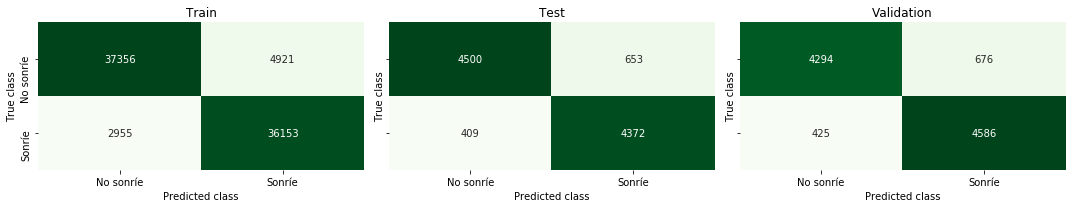

In [26]:
MLP_train_generator.reset()
MLP_test_generator.reset()
MLP_validation_generator.reset()

generators = [("Train", MLP_train_generator),
              ("Test", MLP_test_generator),
              ("Validation", MLP_validation_generator)]

evaluate_model(MLP_model, generators)

### Learning curve

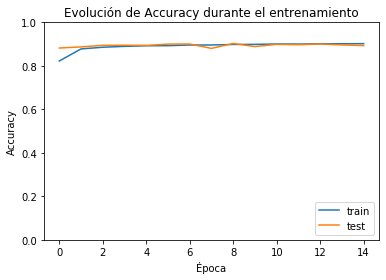

In [27]:
plot_learning_curve(MLP_history)

### Prediction examples with validation

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de MLP, usando los datos de validation, son los siguientes. De cada uno se muestra la clase predicha, la probabilidad arrojada y la clase real. En cuianto a la probabilidad de que la persona sonría es necesario aclarar que si es mayor al 50% corresponde a *Smiling* y si es menor que ese porcentaje a *Not Smiling*.

**Predicciones correctas:**

Found 4990 validated image filenames belonging to 2 classes.



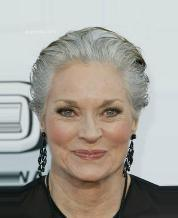
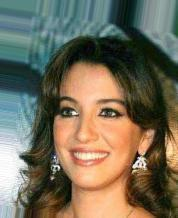
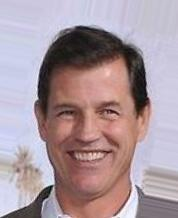
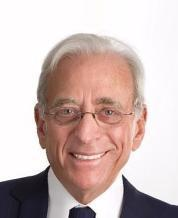
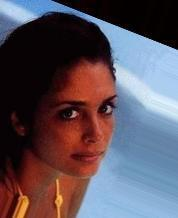
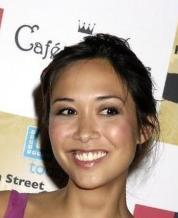
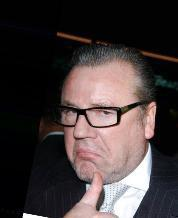
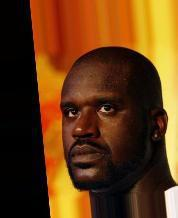
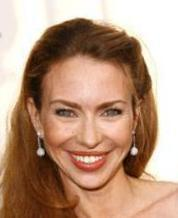
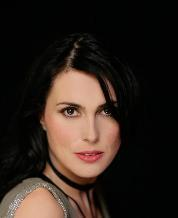
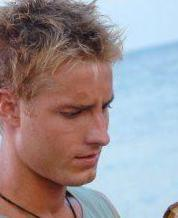
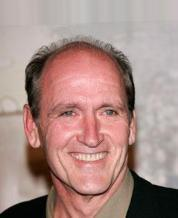
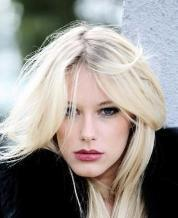
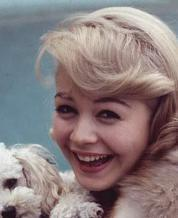
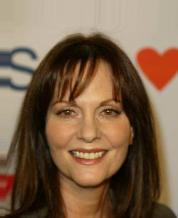
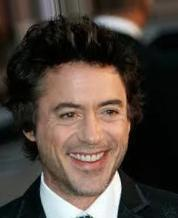

In [28]:
get_predict_samples(df_validation,MLP_model,corret_prediction=True)

**Predicciones incorrectas:**

Found 4990 validated image filenames belonging to 2 classes.



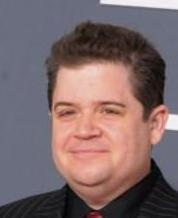
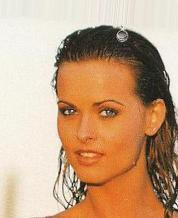
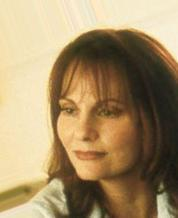
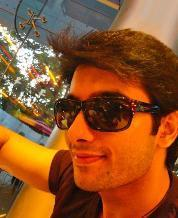
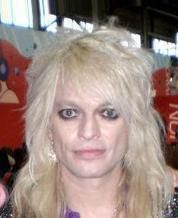
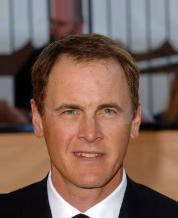
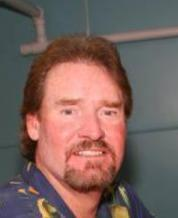
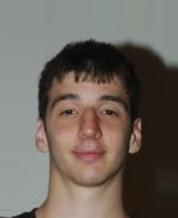
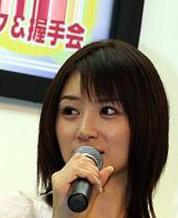
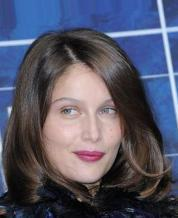
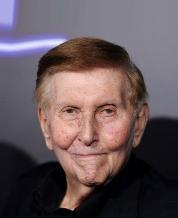
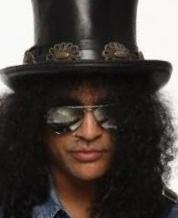
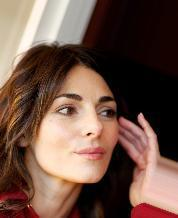
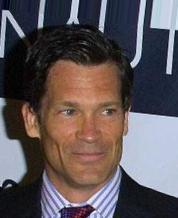
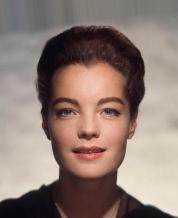
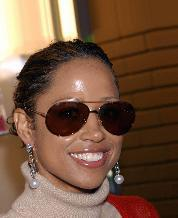

In [29]:
get_predict_samples(df_validation,MLP_model,corret_prediction=False)

# CNN

### Image Generator

In [325]:
# Obtenemos el gerador para cada conjunto de datos
CNN_train_generator = get_generator(df_train)
CNN_test_generator = get_generator(df_test)
CNN_validation_generator = get_generator(df_validation)

Found 81385 validated image filenames belonging to 2 classes.
Found 9934 validated image filenames belonging to 2 classes.
Found 9981 validated image filenames belonging to 2 classes.


### Models

Al igual que con MLP, elegimos "sigmoid" como función de activacion en la capa de salida, y "binary_crossentropy" como función de pérdida. En cuanto a la métrica, seguiremos basándonos en "accuracy".

Decidimos empezar por 10 epocas para analizar una primera tendencia con cada configuracion y luego aumentarlo si es necesario.

El resto de hiperparametros los fuimos modificando experimento a experimento, pero sin llegar a una configuración que se destaque del resto. En todos los casos probados obteniamos valores cercanos al 90% en trest, pero en train se llegaba a escalar hasta un 99%.  

Se hicieron pruebas con las mismas arquitecturas, cambiando las funciones de activacion o el optimizador (un cambio por vez). Ademas probamos con mas capas, mas filtros por capa, cambiando el tamaño del filtro, etc. En muchos casos, al ver que los valores de las métricas se estancaban, no dejamos que finalice el entrenamiento debido al elevado tiempo que esto llevaba.

Ademas, probamos variando los hiperparametros de la red densa que se encuentra al final, pero nada de todo eso nos permitio alcanzar metricas mas allá del 90 o 91 porciento en test.

### Final configuration of the MLP model

Podríamos haber seleccionado varias configuraciones teniendo en cuenta lo dicho anteriormente, pero nos inclinamos a la siguiente porque era una de las que menos tiempo demoraba por época, logrando aún así buenos resultados finales.

In [338]:
#Definición de la arquitectura de la red convolucional
CNN_model = Sequential([
    Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    
    Conv2D(16,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    
    Conv2D(8,kernel_size=(3,3),activation='relu'),
    Dropout(0.1),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(1, activation='sigmoid')
])

In [339]:
CNN_model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [340]:
CNN_train_generator.reset()
CNN_test_generator.reset()

CNN_history = CNN_model.fit(CNN_train_generator, 
              epochs=15,
              workers=4, 
              validation_data=CNN_test_generator
)

Epoch 1/5
2544/2544 [==============================] - 407s 160ms/step - loss: 0.3561 - accuracy: 0.8454 - val_loss: 0.1772 - val_accuracy: 0.8883
Epoch 2/5
2544/2544 [==============================] - 357s 140ms/step - loss: 0.2702 - accuracy: 0.8863 - val_loss: 0.2350 - val_accuracy: 0.8997
Epoch 3/5
2544/2544 [==============================] - 357s 140ms/step - loss: 0.2484 - accuracy: 0.8979 - val_loss: 0.1702 - val_accuracy: 0.9037
Epoch 4/5
2544/2544 [==============================] - 361s 142ms/step - loss: 0.2366 - accuracy: 0.9037 - val_loss: 0.1669 - val_accuracy: 0.9089
Epoch 5/5
2544/2544 [==============================] - 366s 144ms/step - loss: 0.2274 - accuracy: 0.9062 - val_loss: 0.1564 - val_accuracy: 0.9084


### Final metrics

312/312 [==============================] - 32s 101ms/step


,Accuracy,Precision,Recall,F1
Train,0.927222,0.923332,0.925386,0.924358
Test,0.908395,0.904832,0.904832,0.904832
Validation,0.902314,0.901672,0.904011,0.902840


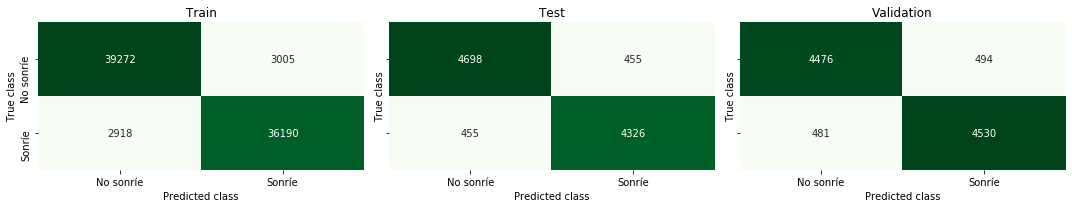

In [341]:
CNN_train_generator.reset()
CNN_test_generator.reset()
CNN_validation_generator.reset()

generators = [("Train", CNN_train_generator),
              ("Test", CNN_test_generator),
              ("Validation", CNN_validation_generator)]

evaluate_model(CNN_model, generators)

### Learning curve

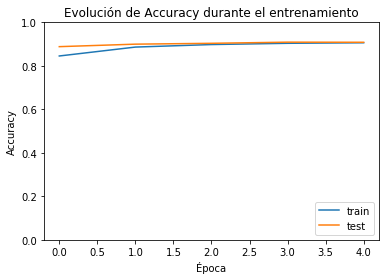

In [342]:
plot_learning_curve(CNN_history)

### Prediction examples with validation

Algunos ejemplos de las predicciones realizadas por el "mejor modelo" de CNN, usando los datos de validation, son los siguientes. Al igual de como se hizo para MLP, se muestra la clase predicha, la probabilidad arrojada y la clase real para cada imagen de entrada.

**Predicciones correctas:**

In [ ]:
get_predict_samples(df_validation,CNN_model,corret_prediction=True)

**Predicciones incorrectas:**

In [ ]:
get_predict_samples(df_validation,CNN_model,corret_prediction=False)

## Conclusions

Como se puede observar en los modelos entrenados, no existen demasiadas diferencias en las capacidades de clasificacion. En test y validation obtuvimos métricas muy similares en accuracy, aproximadas al 90-92%. Esto quiere decir que ambos modelos son buenos clasificando ejemplos nuevos (de cada 100 ejemplos, solo 8-10 ejemplos estaran mal clasificados).

Lo mencionado anteriormente es relativo, ya que al observar los ejemplos mal clasificados podemos decir que, en su mayoría, se tratan de "grises". Es decir, ejemplos que tienen una probabilidad entre el 40% y 60% de estar sonriendo. Al aplicar el redondeo a ese porcentaje es posible la division en clases, pero la seguridad de estar clasificando bien es baja.

Sumado a lo anterior, encontramos ejemplos que, a nuestro parecer, estarian mal clasificados originalmente, siendo la categoría "verdadera" la arrojada por el modelo.